# Patients analysis

## Dataprocessing
### Imports

In [2]:
%matplotlib inline
import pandas as pdb
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from dbspro.notebook import *

In [3]:
from datetime import date

def today():
    return date.today().strftime("%y%m%d")
print(today())

220216


### Data loading

In [8]:
# Load metadata
abc_target = pd.read_csv("../data/patients.abc_target.csv", names=["abc", "target"]).set_index("abc").to_dict()["target"]
display(abc_target)
targets = list(abc_target.values())
targets.remove("Her2_CD63")
display(targets)
sample_names= pd.read_csv("../data/patients.samples.tsv", dtype=str, sep="\t")
samples = sorted(sample_names["Sample"].to_list())
display(samples)
display(sample_names)

{'ABC01': 'EGFR',
 'ABC12': 'Her2_CD63',
 'ABC09': 'CD9',
 'ABC03': 'CD3',
 'ABC18': 'PD1',
 'ABC07': 'CD4',
 'ABC22': 'CD8',
 'ABC19': 'PD-L1',
 'ABC13': 'IGF1R-α',
 'ABC14': 'NY-ESO1',
 'ABC16': 'EpCam'}

['EGFR',
 'CD9',
 'CD3',
 'PD1',
 'CD4',
 'CD8',
 'PD-L1',
 'IGF1R-α',
 'NY-ESO1',
 'EpCam']

['ID_PE002', 'ID_PE009', 'ID_PE011']

Sample    Reads                                          FastqPath
0  ID_PE002  2015296  /Users/pontus.hojer/analysis/DBS-Pro_Exosomes/...
1  ID_PE009  2731408  /Users/pontus.hojer/analysis/DBS-Pro_Exosomes/...
2  ID_PE011   731517  /Users/pontus.hojer/analysis/DBS-Pro_Exosomes/...

In [11]:
# Load data
data_raw = pd.read_csv("../data/patients.tsv.gz", sep="\t")

# Rename ABCs to targets
data_raw.replace({"Target": abc_target}, inplace=True)

# Filter out UMIs with only one read count
print("Size before:", len(data_raw))
data_raw = data_raw[data_raw["ReadCount"] > 1]
print("Size after:", len(data_raw))

Size before: 1078963
Size after: 412756


### Overall QC

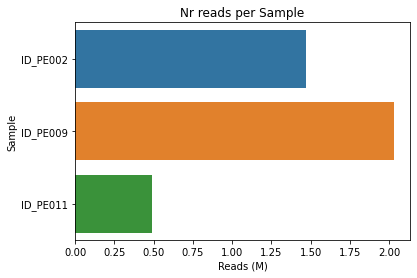

In [15]:
d = data_raw.groupby("Sample", as_index=False).sum()
d["ReadCount"] /= 1_000_000
ax = sns.barplot(data=d, y="Sample", x="ReadCount", order=samples)
_ = ax.set_xlabel("Reads (M)")
_ = ax.set_title("Nr reads per Sample")

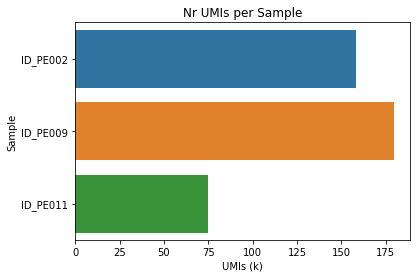

In [16]:
d = data_raw.groupby("Sample", as_index=False).count()
d["UMI"] /= 1_000
ax = sns.barplot(data=d, y="Sample", x="UMI", order=samples)
_ = ax.set_xlabel("UMIs (k)")
_ = ax.set_title("Nr UMIs per Sample")

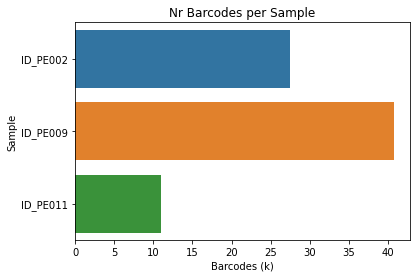

In [17]:
d = data_raw.groupby("Sample").agg({"Barcode":"nunique"})
d["Barcode"] /= 1_000
ax = sns.barplot(data=d, y=d.index, x="Barcode", order=samples)
_ = ax.set_xlabel("Barcodes (k)")
_ = ax.set_title("Nr Barcodes per Sample")

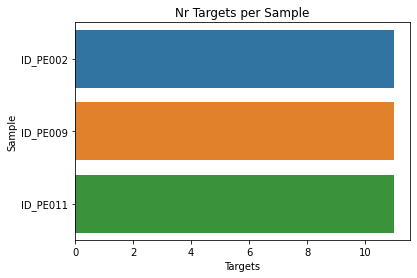

In [18]:
d = data_raw.groupby("Sample").agg({"Target":"nunique"})
ax = sns.barplot(data=d, y=d.index, x="Target", order=samples)
_ = ax.set_xlabel("Targets")
_ = ax.set_title("Nr Targets per Sample")

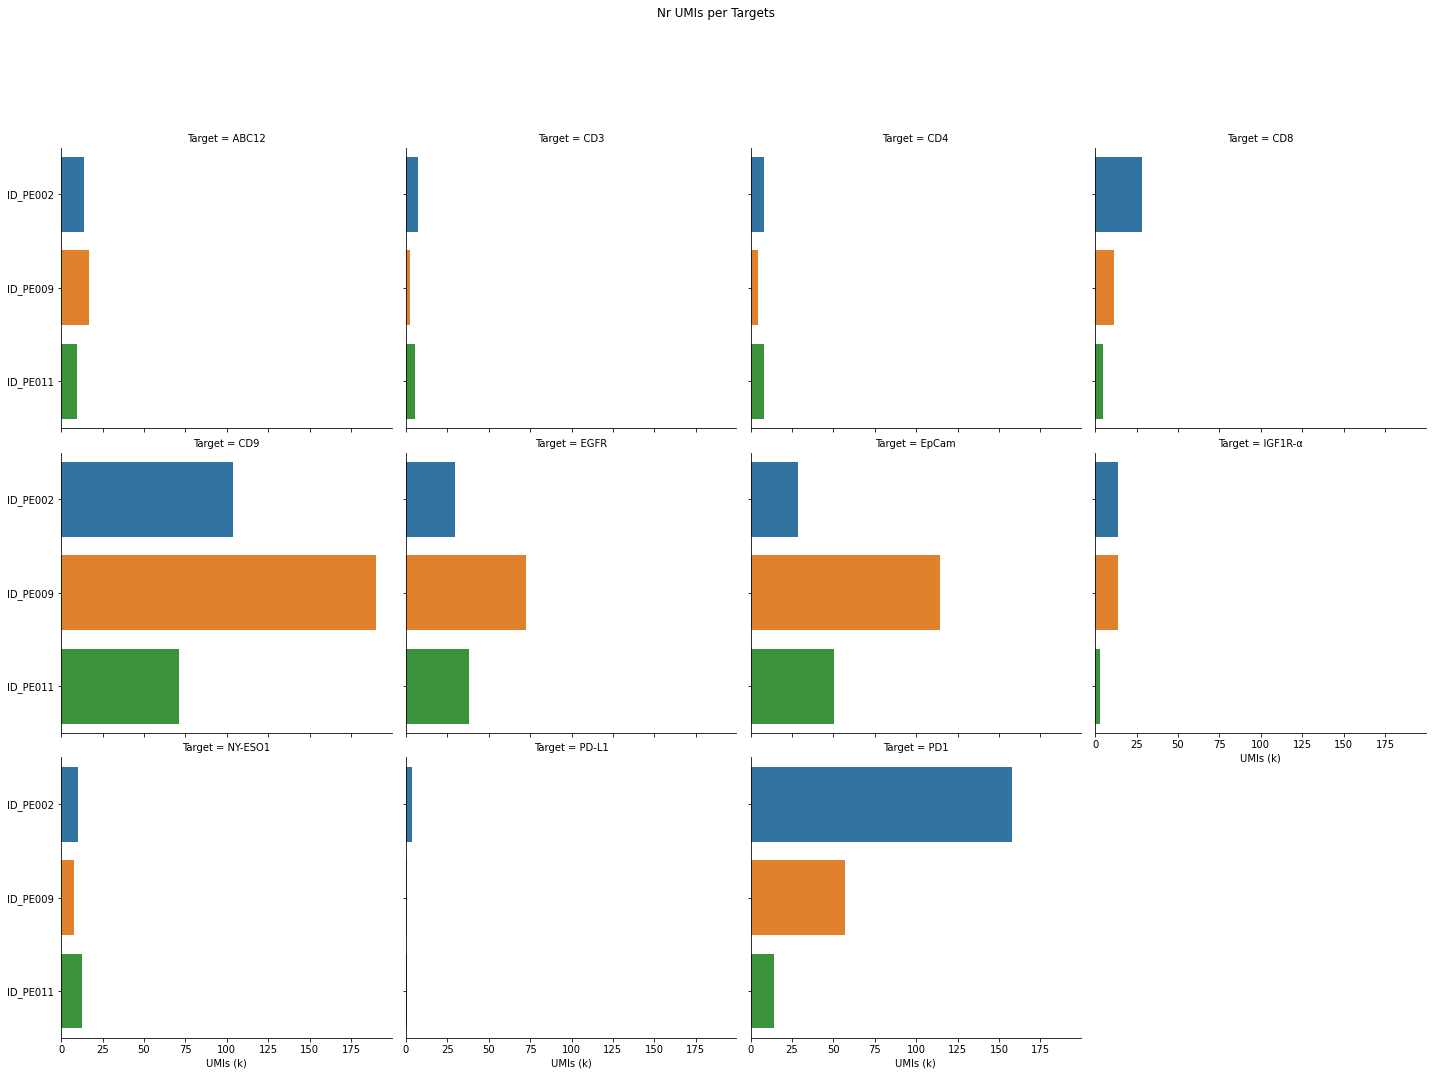

In [12]:
d = data_raw.groupby(["Sample", "Target"], as_index=False).agg({"UMI":"count"})
d["UMI"] /= 1000
g = sns.catplot(data=d, y="Sample", x="UMI",  col="Target", col_wrap=4, kind="bar")
g.fig.subplots_adjust(top=0.85)
_ = g.fig.suptitle("Nr UMIs per Targets")
_ = g.set_axis_labels("UMIs (k)", "")

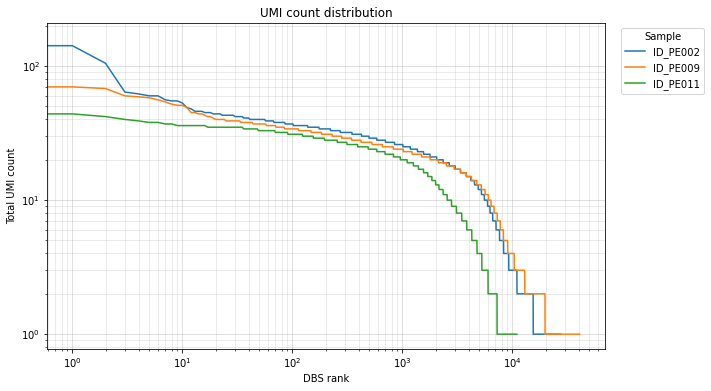

In [20]:
fig, ax = plt.subplots(figsize=(10,6))
ax.set_title("UMI count distribution")
for sample in samples:
    temp = data_raw[data_raw["Sample"] == sample].groupby("Barcode", as_index=False)["UMI"].count().sort_values(by="UMI",ascending=False).reset_index(drop=True)
    try:
        temp.plot(ax=ax, y="UMI", logx=True, logy=True, label=sample)
    except TypeError:
        pass
    
ax.set_xlabel("DBS rank")
ax.set_ylabel("Total UMI count")
ax.grid('on', which='major', axis='y', alpha=0.5 )
ax.grid('on', which='major', axis='x',alpha=0.5)
ax.grid('on', which='minor', axis='y', alpha=0.3)
ax.grid('on', which='minor', axis='x', alpha=0.3)
_ = plt.legend(bbox_to_anchor=(1.02, 1), title="Sample", loc='upper left')

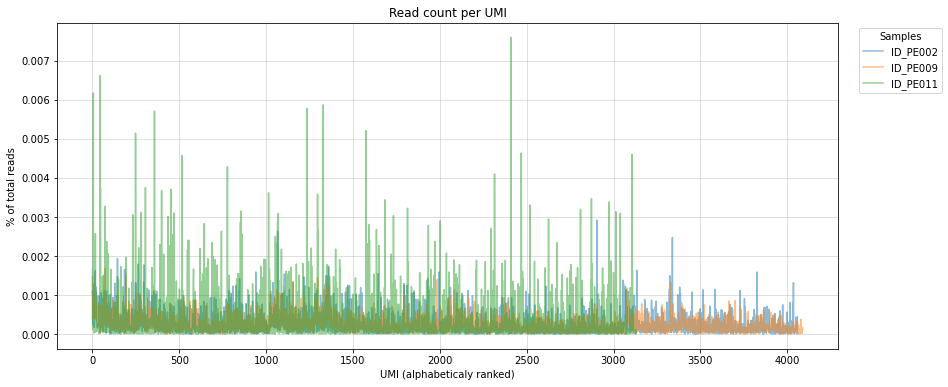

In [21]:
fig, ax = plt.subplots(figsize=(14,6))
ax.set_title("Read count per UMI")
for sample in samples:
    temp = data_raw[data_raw["Sample"] == sample].groupby("UMI", as_index=False)["ReadCount"].sum().sort_values(by="UMI",ascending=False).reset_index(drop=True)
    temp["GC"] = temp["UMI"].apply(lambda x: sum([c in {"G","C"} for c in x])/len(x)) 
    temp["ReadCount"] = temp["ReadCount"]/temp["ReadCount"].sum()
    try:
        temp.plot(ax=ax, y="ReadCount", logx=False, logy=False, label=sample, alpha=0.5)
    except TypeError:
        pass
ax.set_xlabel("UMI (alphabeticaly ranked)")
ax.set_ylabel("% of total reads")
ax.grid('on', which='major', axis='y', alpha=0.5 )
ax.grid('on', which='major', axis='x',alpha=0.5)
ax.grid('on', which='minor', axis='y', alpha=0.3)
ax.grid('on', which='minor', axis='x', alpha=0.3)
_ = plt.legend(bbox_to_anchor=(1.02, 1), title="Samples", loc='upper left')

(-5.0, 200.0)

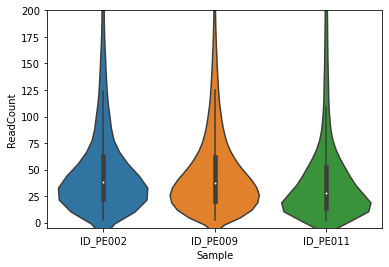

In [24]:
ax = sns.violinplot(data=data_raw.groupby(["Sample","Barcode"], as_index=False)["ReadCount"].sum(), kind="violin", x="Sample", y="ReadCount", bw_adjust=0.1, scale="width")
ax.set_ylim(-5,200)

In [40]:
np.unique(data_raw["Target"])

array(['CD3', 'CD4', 'CD8', 'CD9', 'EGFR', 'EpCam', 'Her2_CD63',
       'IGF1R-α', 'NY-ESO1', 'PD-L1', 'PD1'], dtype=object)

## Functions

In [15]:
from scipy.stats.mstats import gmean

def to_matrix(df, norm=False, on_cells=False, qc=False):
    matrix = df.groupby(["Barcode","Target"], as_index=False)["UMI"].count().set_index("Barcode").pivot(columns="Target", values="UMI").fillna(0)

    if norm:
        matrix = clr_normalize(matrix, on_cells=on_cells)
    
    if qc:
        matrix.qc(inplace=True)
        map_rc = {bc: group["ReadCount"].sum() for bc, group in df.groupby("Barcode")}
        matrix["total_reads"] = matrix.index.to_series().map(map_rc)
    
    return matrix

pd.DataFrame.to_matrix = to_matrix

def to_readmatrix(df, norm=False, on_cells=False, qc=False):
    matrix = df.groupby(["Barcode","Target"], as_index=False)["ReadCount"].sum().set_index("Barcode").pivot(columns="Target", values="ReadCount").fillna(0) 
    if norm:
        matrix = clr_normalize(matrix, on_cells=on_cells)
    
    if qc:
        matrix.qc(inplace=True)
        map_rc = {bc: group["ReadCount"].sum() for bc, group in df.groupby("Barcode")}
        matrix["total_reads"] = matrix.index.to_series().map(map_rc)
    
    return matrix
    
pd.DataFrame.to_readmatrix = to_readmatrix

def clr_normalize(mtx, columns=None, on_cells=False):
    #CLR normalisation
    mtx_copy = mtx.copy()
    
    if not columns:
        columns = mtx_copy.select_dtypes(include=np.number).columns.tolist()

    sub = mtx_copy.loc[:,columns]
    if on_cells:
        # Based on seurat CLR function
        # https://github.com/satijalab/seurat/blob/9843b843ed0c3429d86203011fda00badeb29c2e/R/preprocessing.R#L2192
        sub = sub.apply(lambda x: np.log1p(x / gmean(x[x > 0])))
    else:
        sub = sub.apply(lambda x: (x+1))
        sub = sub.div(gmean(sub), axis=1).applymap(np.log1p)
    mtx_copy.loc[:,columns] = sub
    return mtx_copy

def qc(df, targets=None, inplace=False):
    if inplace:
        matrix = df
    else:
        matrix = df.copy()
        
    if targets is None:
        targets = matrix.select_dtypes(include=np.number).columns.tolist()

    matrix["total_count"] = matrix.loc[:,targets].sum(axis=1)
    matrix["nr_targets"] = matrix.loc[:,targets].gt(0).sum(axis=1)
    return matrix

pd.DataFrame.qc = qc

## Filter and create count matrix

In [60]:
data_count = []
for sample in tqdm(samples):
    print(sample)
    d = data_raw[data_raw["Sample"]==sample]\
            .filter_rc(1)\
            .filter_uc(1)\
            .filter_ratio(2)\
            .filter_target_count(1)\
            .filter_dups(0.5, min_len=2)
    d = d[d['Target']!='Her2_CD63']
    data_count.append(d.to_matrix(qc=True).assign(Sample=sample))
    print("")
data_count = pd.concat(data_count)

  0%|          | 0/3 [00:00<?, ?it/s]

ID_PE002
Filtering molecules per readcount gt 1
Barcodes = 27,455 (-0, -0.0%, runtime:0.017045974731445312 s)
Filtering barcodes by total UMI count gt 1
Barcodes = 15,408 (-12,047, -43.88%, runtime:0.038575172424316406 s)
Filtering barcodes by Reads/UMI ratio gt 2
Barcodes = 14,772 (-636, -4.13%, runtime:0.04239511489868164 s)
Filtering for targets with UMI count gt 1
Barcodes = 14,142 (-630, -4.26%, runtime:0.04250383377075195 s)
Filter barcodes whose UMI + Target combos have a jaccard index >0.5


Parsing pairs:   0%|          | 0.00/100M [00:00<?, ?it/s]

Barcodes = 9,731 (-4,411, -31.19%, runtime:126.57323217391968 s)

ID_PE009
Filtering molecules per readcount gt 1
Barcodes = 40,793 (-0, -0.0%, runtime:0.0201568603515625 s)
Filtering barcodes by total UMI count gt 1
Barcodes = 19,729 (-21,064, -51.64%, runtime:0.043602943420410156 s)
Filtering barcodes by Reads/UMI ratio gt 2
Barcodes = 18,433 (-1,296, -6.57%, runtime:0.04806995391845703 s)
Filtering for targets with UMI count gt 1
Barcodes = 16,757 (-1,676, -9.09%, runtime:0.04554009437561035 s)
Filter barcodes whose UMI + Target combos have a jaccard index >0.5


Parsing pairs:   0%|          | 0.00/140M [00:00<?, ?it/s]

Barcodes = 12,561 (-4,196, -25.04%, runtime:164.49901914596558 s)

ID_PE011
Filtering molecules per readcount gt 1
Barcodes = 10,972 (-0, -0.0%, runtime:0.008393049240112305 s)
Filtering barcodes by total UMI count gt 1
Barcodes = 7,231 (-3,741, -34.1%, runtime:0.01634693145751953 s)
Filtering barcodes by Reads/UMI ratio gt 2
Barcodes = 6,098 (-1,133, -15.67%, runtime:0.02260279655456543 s)
Filtering for targets with UMI count gt 1
Barcodes = 5,580 (-518, -8.49%, runtime:0.018425941467285156 s)
Filter barcodes whose UMI + Target combos have a jaccard index >0.5


Parsing pairs:   0%|          | 0.00/15.6M [00:00<?, ?it/s]

Barcodes = 4,844 (-736, -13.19%, runtime:21.59654688835144 s)



In [61]:
data_count.groupby("Sample").count()["total_count"]

Sample
ID_PE002     9598
ID_PE009    12410
ID_PE011     4818
Name: total_count, dtype: int64

In [4]:
# Save counts to simply rerunning analysis from here.
#data_count.to_csv("../data/patients.counts.tsv.gz", sep="\t")

# Comment out the row above and run the code below if rerunning analysis
data_count = pd.read_csv("../data/patients.counts.tsv.gz", sep="\t").set_index("Barcode")

## Per Droplet QC

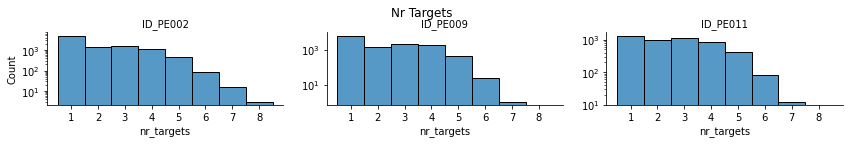

In [63]:
bins = np.array(range(1,data_count["nr_targets"].max()+1))

g = sns.displot(data_count, x="nr_targets", col="Sample", bins=bins, 
                height=2, aspect=2, facet_kws={'sharey': False})
g.fig.subplots_adjust(top=0.8)
_ = g.fig.suptitle("Nr Targets")
g.set(yscale="log", xticks = bins[:-1] + 0.5, xticklabels=bins[:-1])
g.set_titles("{col_name}")

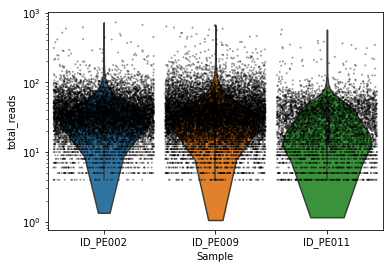

In [64]:
ax = sns.violinplot(data=data_count, y="total_reads", x="Sample", scale="width", cut=0.5)
ax = sns.stripplot(data=data_count, y="total_reads", x="Sample", size=2, jitter=0.45, color="black", alpha=0.4)
#ax.set_ylim(0,120)
ax.set_yscale("log")



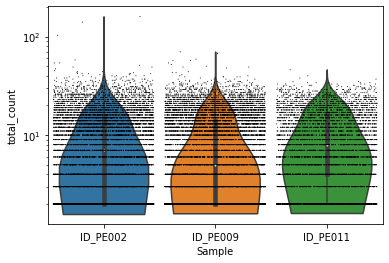

In [65]:
ax = sns.violinplot(data=data_count, y="total_count", x="Sample", bw=0.5, scale="width", cut=0.1)
ax = sns.stripplot(data=data_count, y="total_count", x="Sample", size=1, jitter=0.45, color="black")

ax.set_yscale("log")
#ax.axhline(15, color="r")
#ax.set_ylim(0,20)

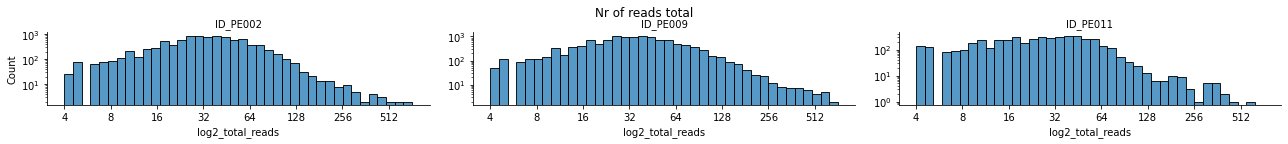

In [66]:
import matplotlib.ticker as tkr
d = data_count.copy()
d["log2_total_reads"] = np.log2(d["total_reads"])
g = sns.displot(d, x="log2_total_reads", col="Sample", col_wrap=3, bins=40,
                height=2, aspect=3, facet_kws={'sharey': False})
g.fig.subplots_adjust(top=0.8)
_ = g.fig.suptitle("Nr of reads total")
g.set(yscale="log", )
g.set_titles("{col_name}")
for ax in g.axes.flat:
    ax.xaxis.set_major_formatter(tkr.FuncFormatter(lambda x, p: str(int(2**x))))

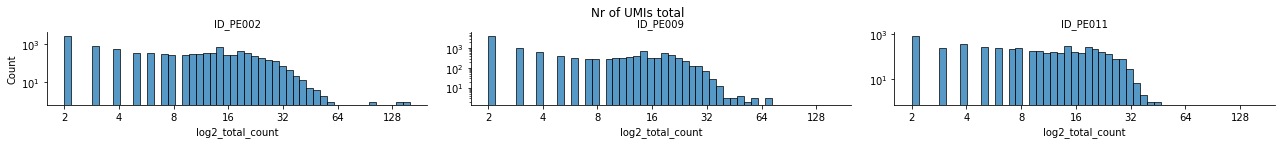

In [67]:
d = data_count.copy()
d["log2_total_count"] = np.log2(d["total_count"])
g = sns.displot(d, x="log2_total_count", col="Sample", col_wrap=3, bins=50,
                height=2, aspect=3, facet_kws={'sharey': False})
g.fig.subplots_adjust(top=0.8)
_ = g.fig.suptitle("Nr of UMIs total")
g.set(yscale="log", )
g.set_titles("{col_name}")
for ax in g.axes.flat:
    ax.xaxis.set_major_formatter(tkr.FuncFormatter(lambda x, p: str(int(2**x))))

## Filter data further

In [5]:
data_filt = data_count.groupby("Sample", as_index=False)\
    .apply(lambda x: x[(x["total_count"]>1) & (x["total_count"] < 25)])

In [6]:
data_filt.head()

CD3  CD4  CD8  CD9  EGFR  EpCam  IGF1R-α  NY-ESO1  \
  Barcode                                                                   
0 CAAACAATCTATCAATCTGC  0.0  0.0  0.0  3.0   2.0    0.0      0.0      0.0   
  CAAACAATGTACCAAACAGT  0.0  0.0  0.0  0.0   0.0    0.0      3.0      0.0   
  CAAACAATTAGTGTGATACT  0.0  0.0  0.0  0.0   0.0    0.0      0.0      0.0   
  CAAACACAGACCCAGCGTCA  2.0  0.0  2.0  3.0   0.0    0.0      0.0      0.0   
  CAAACACAGACCCTCCTGAA  0.0  0.0  0.0  0.0   0.0    0.0      0.0      0.0   

                        PD-L1   PD1    Sample  total_count  nr_targets  \
  Barcode                                                                
0 CAAACAATCTATCAATCTGC    0.0   3.0  ID_PE002            8           3   
  CAAACAATGTACCAAACAGT    0.0   0.0  ID_PE002            3           1   
  CAAACAATTAGTGTGATACT    0.0   4.0  ID_PE002            4           1   
  CAAACACAGACCCAGCGTCA    0.0  13.0  ID_PE002           20           4   
  CAAACACAGACCCTCCTGAA    0.0  10.0  ID_PE002           10           1   

                        total_reads  
  Barcode                            
0 CAAACAATCTATCAATCTGC           19  
  CAAACAATGTACCAAACAGT           18  
  CAAACAATTAGTGTGATACT           16  
  CAAACACAGACCCAGCGTCA           47  
  CAAACACAGACCCTCCTGAA           30

In [7]:
data_filt.groupby("Sample").count()["total_count"]

Sample
ID_PE002     9064
ID_PE009    11920
ID_PE011     4565
Name: total_count, dtype: int64

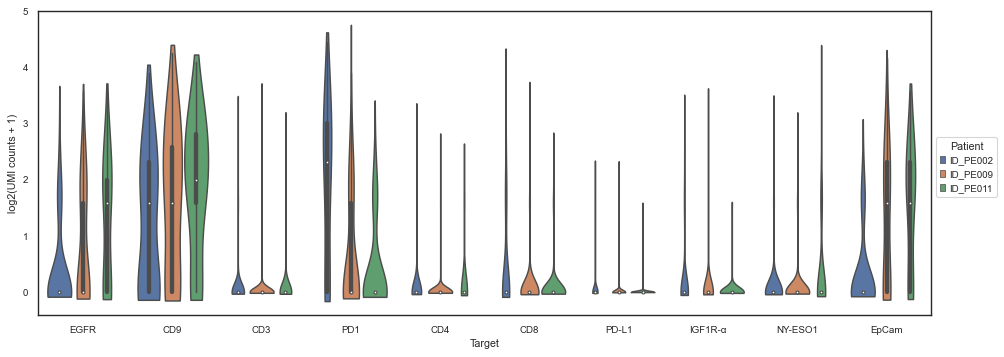

In [414]:
d=data_filt.melt(id_vars="Sample", value_vars=targets).copy()
d["value"] = np.log2(d["value"] + 1)
fig, ax = plt.subplots(figsize=(18,5))
ax = sns.violinplot(ax=ax, data=d, x="variable", y="value", hue="Sample", 
                    scale="area", bw=0.6, cut=0.2, linewidth=1.3, inner="box") 
_ = ax.set_ylabel("log2(UMI counts + 1)")
_ = ax.set_xlabel("Target")
fig.subplots_adjust(right=0.8)
_ = plt.legend(bbox_to_anchor=(1, 0.6), title="Patient", loc='upper left')

for ext in ["png", "svg"]:
    plt.savefig(f"../figures/{today()}.Patients.violinplots.{ext}", dpi=300)

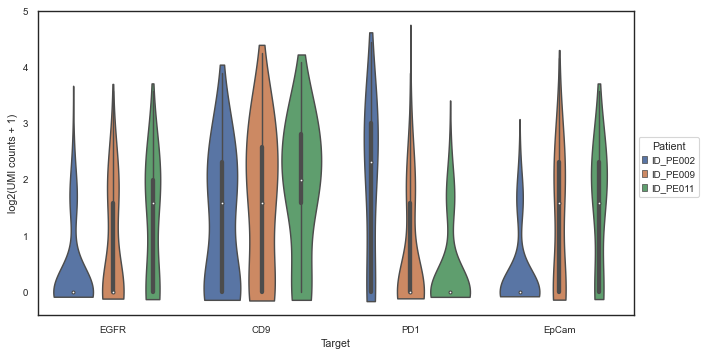

In [415]:
d=data_filt.melt(id_vars="Sample", value_vars=["EGFR","CD9", "PD1", "EpCam"]).copy()
d["value"] = np.log2(d["value"] + 1)
fig, ax = plt.subplots(figsize=(12,5))
ax = sns.violinplot(ax=ax, data=d, x="variable", y="value", hue="Sample", 
                    scale="area", bw=0.6, cut=0.2, linewidth=1.3, inner="box") 
_ = ax.set_ylabel("log2(UMI counts + 1)")
_ = ax.set_xlabel("Target")
fig.subplots_adjust(right=0.8)
_ = plt.legend(bbox_to_anchor=(1, 0.6), title="Patient", loc='upper left')


for ext in ["png", "svg"]:
    plt.savefig(f"../figures/{today()}.Patients.violinplots_select.{ext}", dpi=300)

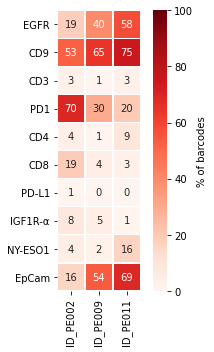

In [12]:
d = data_filt.copy()
d.loc[:,targets] = d.loc[:,targets].clip(upper=1)
d = d.loc[:, list(targets) + ["Sample"]]
fig, ax = plt.subplots(figsize=(4,5))
sns.heatmap(data=d.groupby("Sample").apply(lambda x: 100 * x.sum() / x.count()).T, ax=ax,
           square=True, vmin=0, vmax=100, annot=True, fmt='.0f',
           linewidths=.5, cmap="Reds", cbar_kws={"label":"% of barcodes"})
_ = plt.ylabel("")
_ = plt.xlabel("")
plt.tight_layout()

for ext in ["png", "svg"]:
    plt.savefig(f"../figures/{today()}.Patients.heatmap_targets.{ext}", dpi=300)

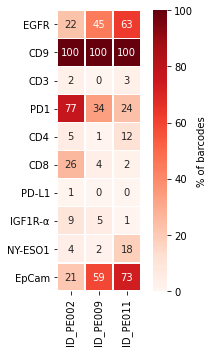

In [13]:
d = data_filt[data_filt["CD9"] > 0].copy()
d.loc[:,targets] = d.loc[:,targets].clip(upper=1)
d = d.loc[:, list(targets) + ["Sample"]]
fig, ax = plt.subplots(figsize=(4,5))
sns.heatmap(data=d.groupby("Sample").apply(lambda x: 100 * x.sum() / x.count()).T, ax=ax,
           square=True, vmin=0, vmax=100, annot=True, fmt='.0f',
           linewidths=.5, cmap="Reds", cbar_kws={"label":"% of barcodes"})
_ = plt.ylabel("")
_ = plt.xlabel("")
plt.tight_layout()

#for ext in ["png", "svg"]:
#    plt.savefig(f"../figures/{today()}.Patients.heatmap_targets.{ext}", dpi=300)

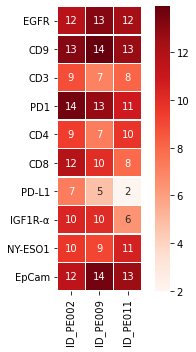

In [18]:
d = data_filt.copy()
d.loc[:,targets] = d.loc[:,targets].clip(upper=1)
d = d.loc[:, list(targets) + ["Sample"]]
fig, ax = plt.subplots(figsize=(4,5))
sns.heatmap(data=d.groupby("Sample").apply(lambda x: np.log2(x.sum())+1).T, ax=ax,
           square=True, annot=True, fmt='.0f',
           linewidths=.5, cmap="Reds")#, cbar_kws={"label":"% of barcodes"})
_ = plt.ylabel("")
_ = plt.xlabel("")
plt.tight_layout()

#for ext in ["png", "svg"]:
#    plt.savefig(f"../figures/{today()}.Patients.heatmap_targets.{ext}", dpi=300)

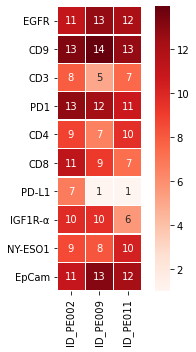

In [17]:
d = data_filt[data_filt["CD9"] > 0].copy()
d.loc[:,targets] = d.loc[:,targets].clip(upper=1)
d = d.loc[:, list(targets) + ["Sample"]]
fig, ax = plt.subplots(figsize=(4,5))
sns.heatmap(data=d.groupby("Sample").apply(lambda x: np.log2(x.sum())+1).T, ax=ax,
           square=True, annot=True, fmt='.0f',
           linewidths=.5, cmap="Reds")#, cbar_kws={"label":"% of barcodes"})
_ = plt.ylabel("")
_ = plt.xlabel("")
plt.tight_layout()

#for ext in ["png", "svg"]:
#    plt.savefig(f"../figures/{today()}.Patients.heatmap_targets.{ext}", dpi=300)

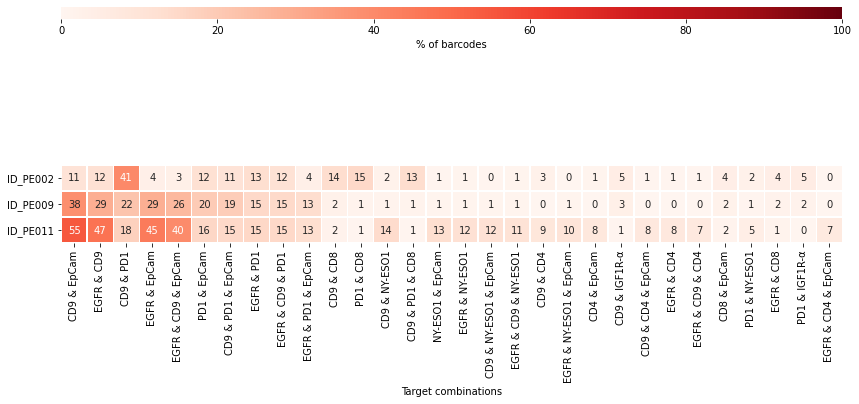

In [11]:
d = data_filt.copy()
combos=[]
for i in range(2,4):
    for ts in combinations(targets, i):
        combo = " & ".join(ts)
        combos.append(combo)
        ts_list = list(ts)
        t = ts_list.pop()
        temp = (d[t] > 0)
        while ts_list:
            t = ts_list.pop()
            temp = np.logical_and(temp, (d[t] > 0))
        
        d[combo] = temp.astype(int) 

d = d.loc[:,combos+ ["Sample"]]
d = d.groupby("Sample").apply(lambda x: 100 * x.sum() / x.count())
maxd = d.mean()#agg(lambda x: x.std()/x.mean()).copy()
maxd.name = "max"
d = d.append(maxd)
d = d.sort_values(by="max", axis=1, ascending=False)
d = d.iloc[:3,:30]
grid_kws = {"height_ratios": (.03, .9), "hspace": .01}
f, (cbar_ax, ax) = plt.subplots(2, gridspec_kw=grid_kws, figsize=(14,7))
ax = sns.heatmap(data=d, ax=ax, cbar_ax=cbar_ax, 
                 cbar_kws={"orientation": "horizontal", "label":"% of barcodes"},
                 square=True, vmin=0, vmax=100, annot=True, fmt='.0f',
                 linewidths=.5, cmap="Reds", xticklabels=1,
                 annot_kws={"fontsize":10})
_ = plt.xlabel("Target combinations")
_ = plt.ylabel("")

#for ext in ["png", "svg"]:
#    plt.savefig(f"../figures/{today()}.Patients.heatmap_top30_combos.{ext}", dpi=300)

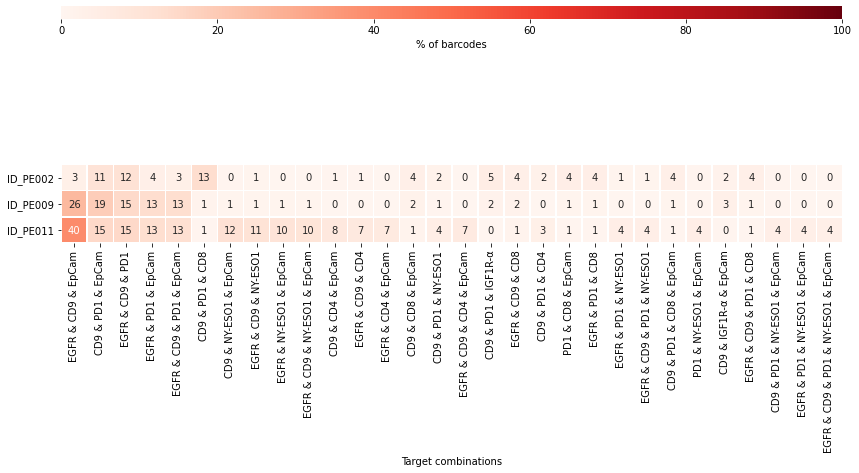

In [22]:
d = data_filt.copy()
combos=[]
for i in range(3,6):
    for ts in combinations(targets, i):
        combo = " & ".join(ts)
        combos.append(combo)
        ts_list = list(ts)
        t = ts_list.pop()
        temp = (d[t] > 0)
        while ts_list:
            t = ts_list.pop()
            temp = np.logical_and(temp, (d[t] > 0))
            if temp.all():
                break
        
        d[combo] = temp.astype(int) 

d = d.loc[:,combos+ ["Sample"]]
d = d.groupby("Sample").apply(lambda x: 100 * x.sum() / x.count())
maxd = d.mean()#agg(lambda x: x.std()/x.mean()).copy()
maxd.name = "max"
d = d.append(maxd)
d = d.sort_values(by="max", axis=1, ascending=False)
d = d.iloc[:3,:30]
grid_kws = {"height_ratios": (.03, .9), "hspace": .01}
f, (cbar_ax, ax) = plt.subplots(2, gridspec_kw=grid_kws, figsize=(14,7))
ax = sns.heatmap(data=d, ax=ax, cbar_ax=cbar_ax, 
                 cbar_kws={"orientation": "horizontal", "label":"% of barcodes"},
                 square=True, vmin=0, vmax=100, annot=True, fmt='.0f',
                 linewidths=.5, cmap="Reds", xticklabels=1,
                 annot_kws={"fontsize":10})
_ = plt.xlabel("Target combinations")
_ = plt.ylabel("")

#for ext in ["png", "svg"]:
#    plt.savefig(f"../figures/{today()}.Patients.heatmap_top30_combos.{ext}", dpi=300)

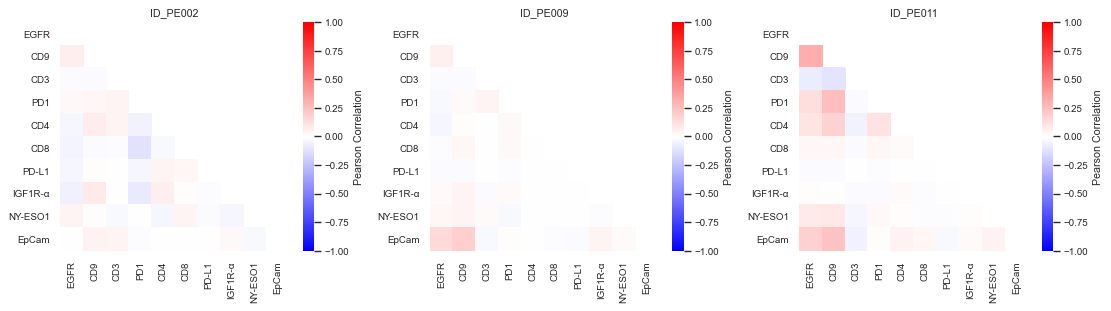

In [371]:
sns.set(font_scale=0.8, style="white")
fig, axes = plt.subplots(ncols=3, figsize=(14,6))
for s, ax in zip(samples, axes.ravel()):
    corr = data_filt[(data_filt["Sample"]==s) & (data_filt["nr_targets"]>1)].loc[:,targets].corr("pearson", min_periods=100)
    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(mask)] = True
    ax = sns.heatmap(corr, mask=mask, cmap="bwr", square=True, vmin=-1, vmax=1, 
                     #annot=True, fmt=".2f", annot_kws={"fontsize":7}, 
                     ax=ax,
                     cbar_kws={"label":"Pearson Correlation", "shrink":.5},)
    ax.set_title(s)
#    plt.tight_layout()
#    for ext in ["png", "svg"]:
#        plt.savefig(f"images/210429_Patient_{l}_pearson_correlation_heatmap.{ext}", dpi=300)
#    plt.show()
plt.tight_layout()


## Scanpy all

In [258]:
import scanpy as sc
sc.settings.verbosity = 1             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')
sc.settings.figdir = "../figures"

scanpy==1.7.2 anndata==0.7.6 umap==0.5.1 numpy==1.19.2 scipy==1.5.2 pandas==1.1.5 scikit-learn==0.24.1 statsmodels==0.12.2 python-igraph==0.9.1 louvain==0.7.0


In [259]:
d = data_filt.copy()
X = d.loc[:,targets].values
obs = d.loc[:, ["total_count", "total_reads", "nr_targets", "Sample"]].reset_index()
var = pd.DataFrame(index=targets)
adata = sc.AnnData(X, obs, var)

/Users/pontus.hojer/miniconda3/envs/dbspro/lib/python3.6/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [260]:
adata

AnnData object with n_obs × n_vars = 25549 × 10
    obs: 'level_0', 'Barcode', 'total_count', 'total_reads', 'nr_targets', 'Sample'

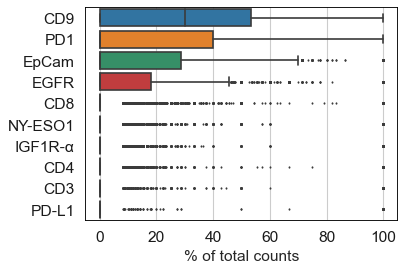

In [261]:
sc.pl.highest_expr_genes(adata, n_top=10, )

... storing 'Sample' as categorical


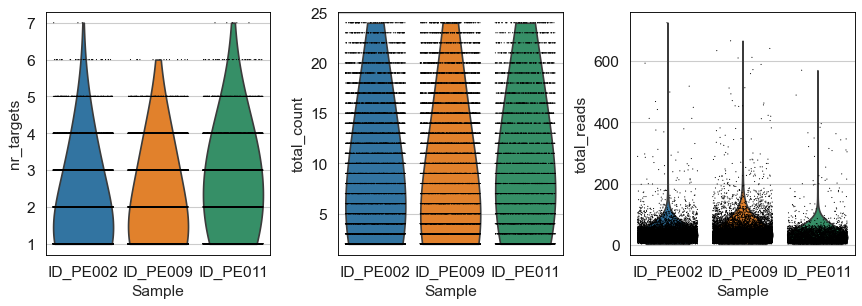

In [262]:
sc.pl.violin(adata, ['nr_targets', 'total_count', "total_reads"],
             jitter=0.4, multi_panel=True, bw=1, groupby="Sample")

In [263]:
target_counts = adata.var.copy()
target_counts["count"] = (adata.X != 0).sum(axis=0)

target_counts

count
EGFR      9047
CD9      15973
CD3        436
PD1      10792
CD4        841
CD8       2400
PD-L1       91
IGF1R-α   1270
NY-ESO1   1423
EpCam    11028

In [264]:
sc.pp.filter_cells(adata, min_genes=3)
#sc.pp.filter_genes(adata, min_cells=100)

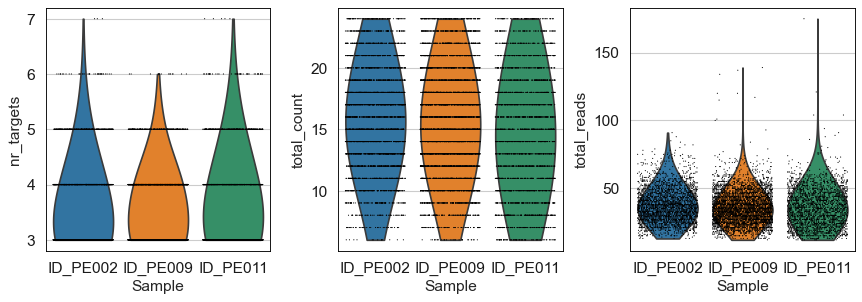

In [265]:
sc.pl.violin(
    adata, 
    ['nr_targets', 'total_count', "total_reads"],
    jitter=0.4, multi_panel=True, bw=1, groupby="Sample"
)

In [266]:
print(adata.obs['Sample'].value_counts())

ID_PE009    4137
ID_PE002    2806
ID_PE011    2291
Name: Sample, dtype: int64


In [13]:
def clr_normalize_adata(adata, on_cells=False, inplace=True):
    """Normalize count vector for each cell, i.e. for each row of .X"""
    def seurat_clr(x):
        s = np.sum(np.log1p(x[x > 0]))
        exp = np.exp(s / len(x))
        return np.log1p(x / exp)
   
    if not inplace:
        adata = adata.copy()

    # apply to dense or sparse matrix, along axis. returns dense matrix
    if on_cells:
        adata.X = np.apply_along_axis(seurat_clr, 1, adata.X)
    else:
        x = np.array(adata.X)
        adata.X = np.log1p(np.divide(x, gmean(x[x>0], axis=0)))
    return adata

In [270]:
adata

AnnData object with n_obs × n_vars = 9234 × 8
    obs: 'level_0', 'Barcode', 'total_count', 'total_reads', 'nr_targets', 'Sample', 'n_genes'
    var: 'n_cells'
    uns: 'Sample_colors'

In [267]:
adata.raw = adata
#clr_normalize_adata(adata, on_cells=True, inplace=True)
for s in samples:
    #clr_normalize(adata[adata.obs.Sample == s, :], on_cell=False, inplace=True)
    clr_normalize_adata(adata[adata.obs.Sample == s, :], on_cells=False, inplace=True)

Text(0, 0.5, 'log2(x+1)')

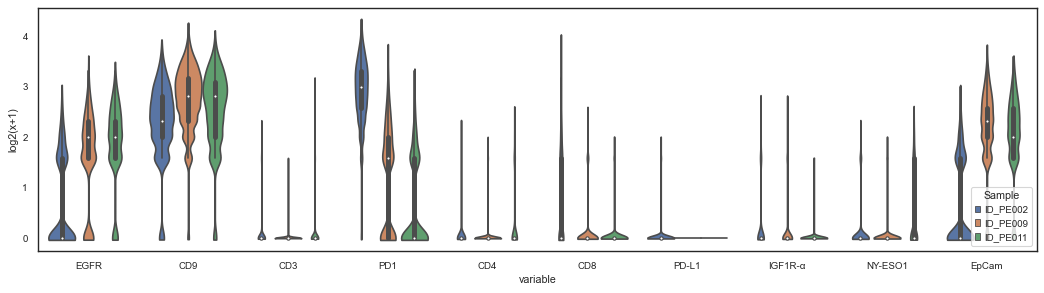

In [381]:
#plotdf = pd.DataFrame(data=adata.X, columns=adata.var.index)
plotdf = pd.DataFrame(data=np.log2(adata.raw.X + 1), columns=adata.var.index)
plotdf["Sample"] = adata.obs["Sample"].values

plotdf.melt(id_vars="Sample")
fig, ax = plt.subplots(figsize=(16,4))
ax = sns.violinplot(data=plotdf.melt(id_vars="Sample"), x="variable", y="value", hue="Sample", ax=ax, cut=0.2, scale="area")
ax.set_ylabel("log2(x+1)")

Text(0.5, 0, 'Target')

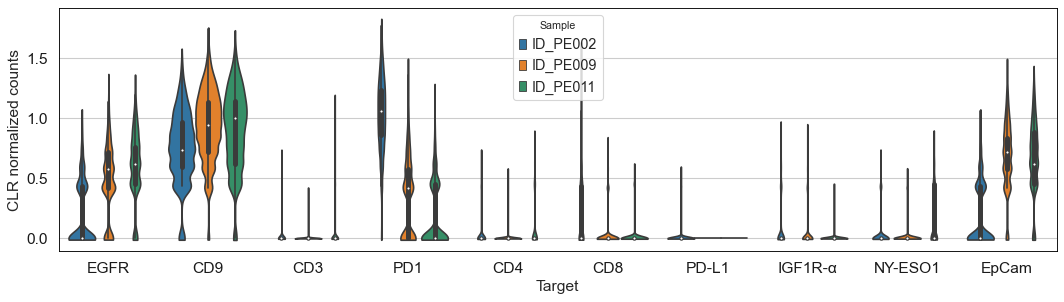

In [269]:
plotdf = pd.DataFrame(data=adata.X, columns=adata.var.index)
#plotdf = pd.DataFrame(data=np.log1p(adata.raw.X), columns=adata.var.index)
plotdf["Sample"] = adata.obs["Sample"].values

plotdf.melt(id_vars="Sample")
fig, ax = plt.subplots(figsize=(16,4))
ax = sns.violinplot(data=plotdf.melt(id_vars="Sample"), x="variable", y="value", hue="Sample", ax=ax, cut=0.2)
ax.set_ylabel("CLR normalized counts")
ax.set_xlabel("Target")

In [270]:
sc.tl.pca(adata, svd_solver='arpack')

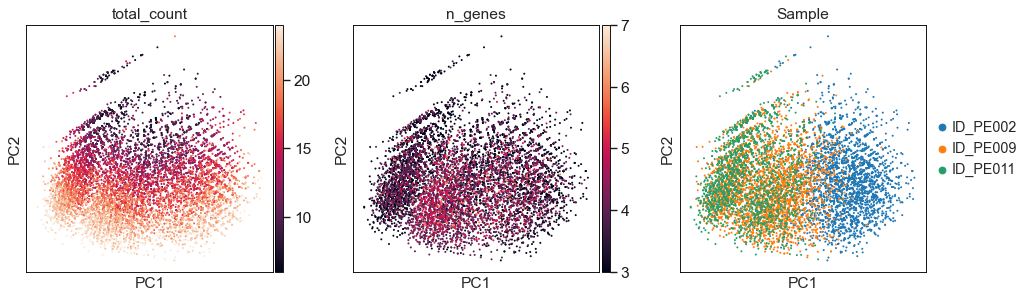

In [271]:
sc.pl.pca(adata, color=['total_count', 'n_genes', 'Sample'])

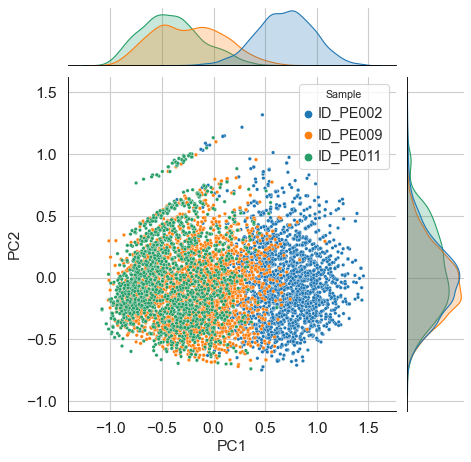

In [272]:
plotdf = sc.get.obs_df(adata, keys=["Sample"], obsm_keys=[("X_pca",0),("X_pca",1)])
plotdf.columns = ['Sample', 'PC1', 'PC2']
g = sns.jointplot(data=plotdf, x="PC1", y="PC2", hue="Sample", 
                  kind="scatter", s=10, marginal_kws={"common_norm": False})

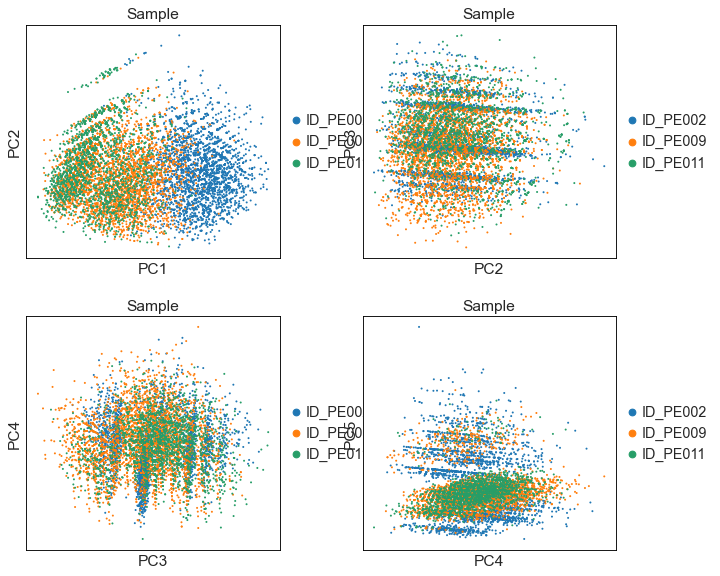

In [273]:
sc.pl.pca(adata, color='Sample', components = ['1,2','2,3', '3,4','4,5'], ncols=2)

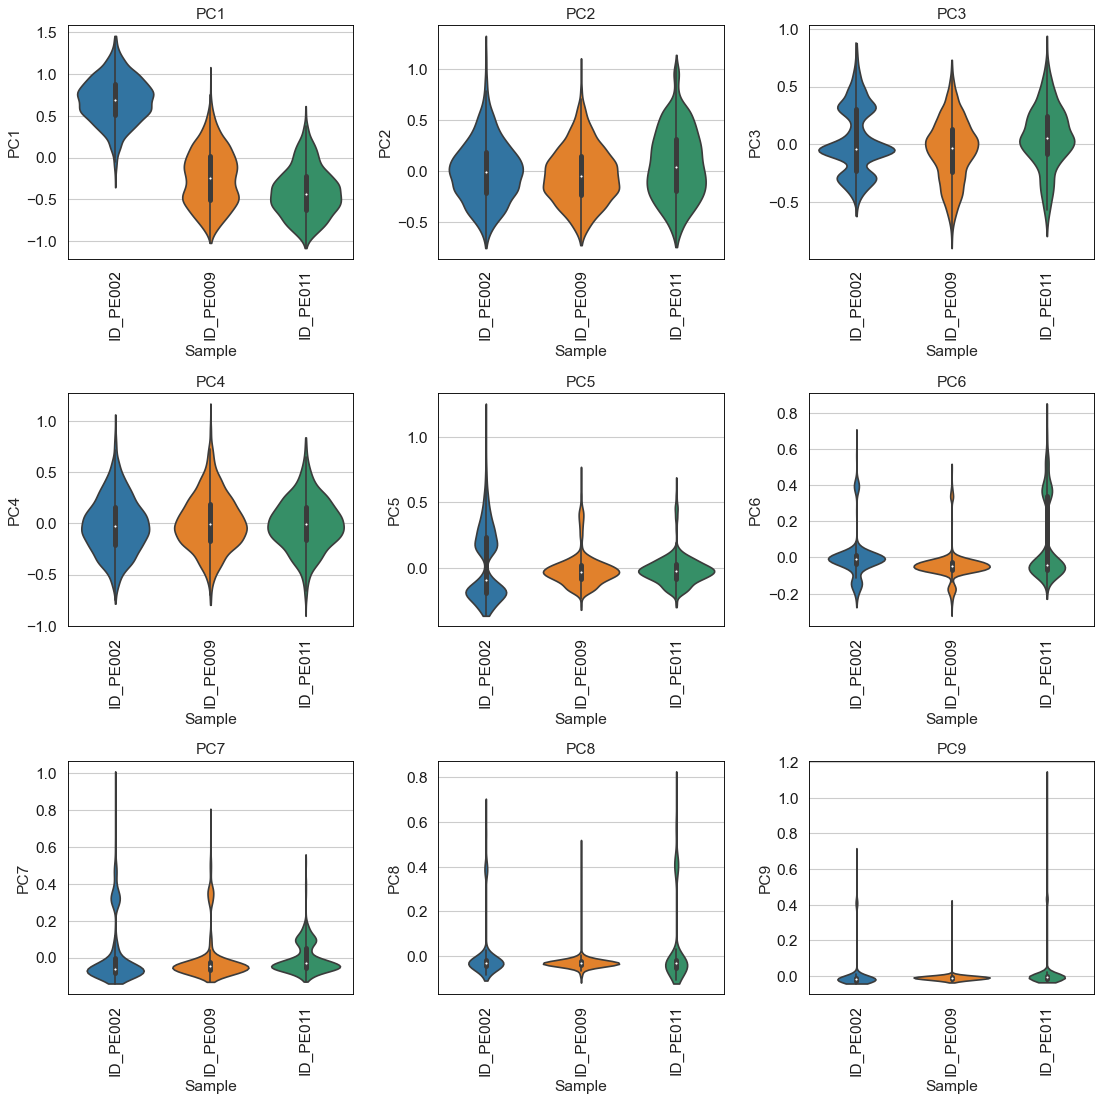

In [274]:
pcs = [f"PC{i}" for i in range(1, adata.obsm["X_pca"].shape[1]+1)]
df = pd.DataFrame(data = adata.obsm["X_pca"], columns=pcs)
df["Sample"] = adata.obs["Sample"].values

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(14,14))
for pc, ax in zip(pcs, axes.ravel()):
    ax = sns.violinplot(data=df, x="Sample", y=pc, ax=ax, cut=0, bw_adjust=0.1)
    ax.set_title(pc)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.tight_layout()

computing density on 'PCA'
/Users/pontus.hojer/miniconda3/envs/dbspro/lib/python3.6/site-packages/scanpy/plotting/_tools/__init__.py:1186: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("YlOrRd"))
  color_map.set_over('black')
/Users/pontus.hojer/miniconda3/envs/dbspro/lib/python3.6/site-packages/scanpy/plotting/_tools/__init__.py:1187: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("YlOrRd"))
  color_map.set_under('lightgray')
/Users/pontus.hojer/miniconda3/envs/dbspro/lib/python3.6/site-packages/scanpy/plotting/_tools/scatterplots.py:

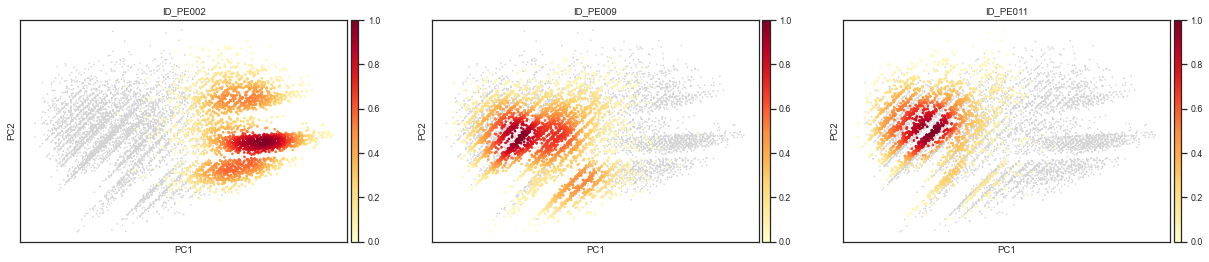

In [163]:
sc.tl.embedding_density(adata, basis="PCA", groupby="Sample")
sc.pl.embedding_density(adata, basis="PCA", key="pca_density_Sample", bg_dotsize=10, fg_dotsize=30)

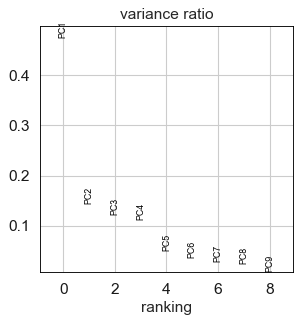

In [276]:
sc.pl.pca_variance_ratio(adata, log=False, n_pcs=8)

In [277]:
sc.pp.neighbors(adata, n_neighbors=100, n_pcs=None)

0.1


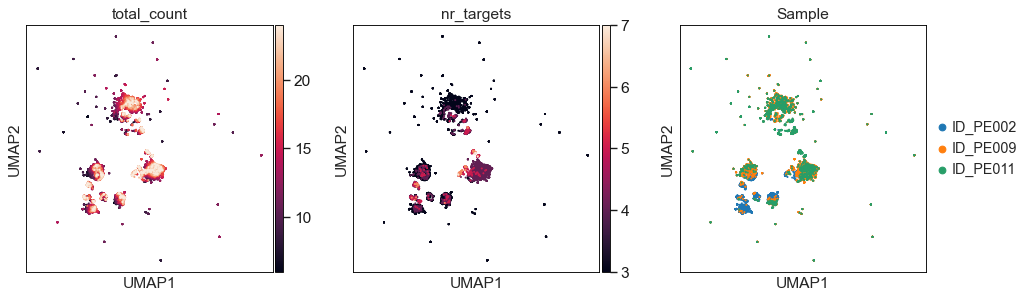

0.3


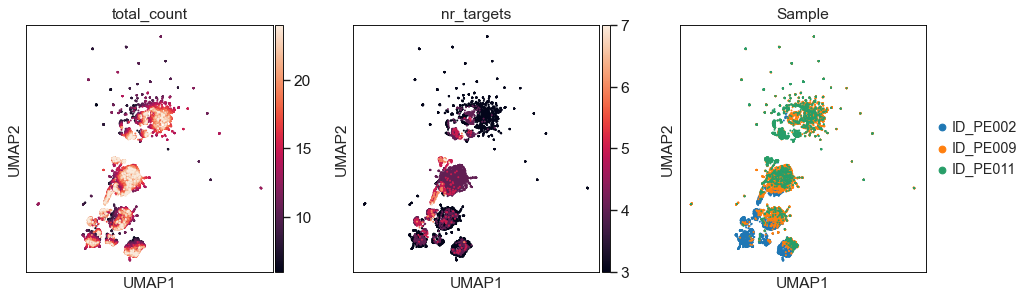

0.5


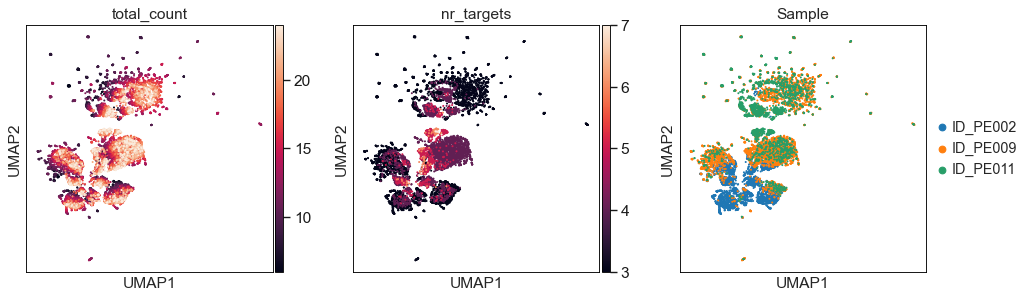

0.7


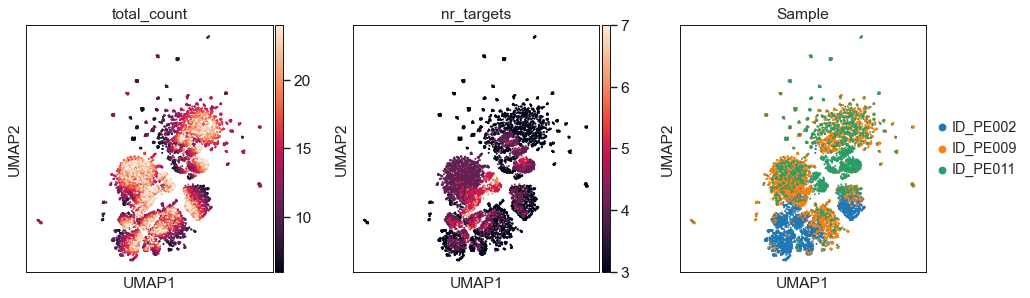

0.9


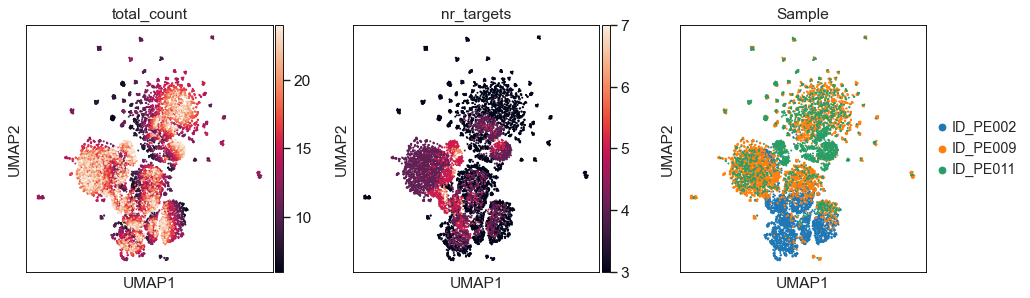

In [278]:
for dist in [0.1, 0.3, 0.5, 0.7, 0.9]:
    print(dist)
    sc.tl.umap(adata, min_dist=dist)
    sc.pl.umap(adata, color=['total_count', 'nr_targets', 'Sample'])
    plt.show()

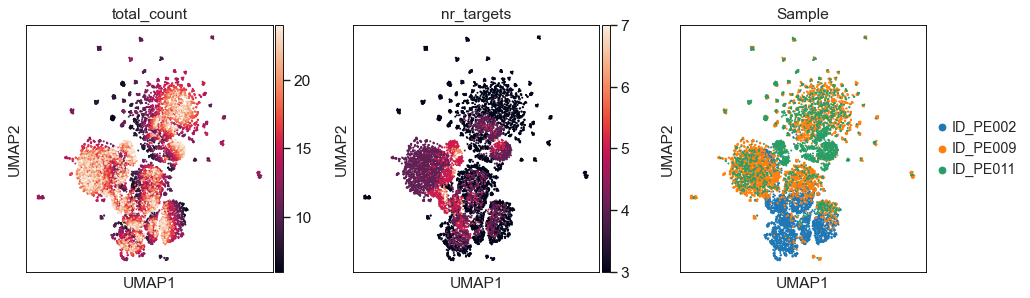

In [279]:
sc.tl.umap(adata, min_dist=0.9)
sc.pl.umap(adata, color=['total_count', 'nr_targets', 'Sample'])

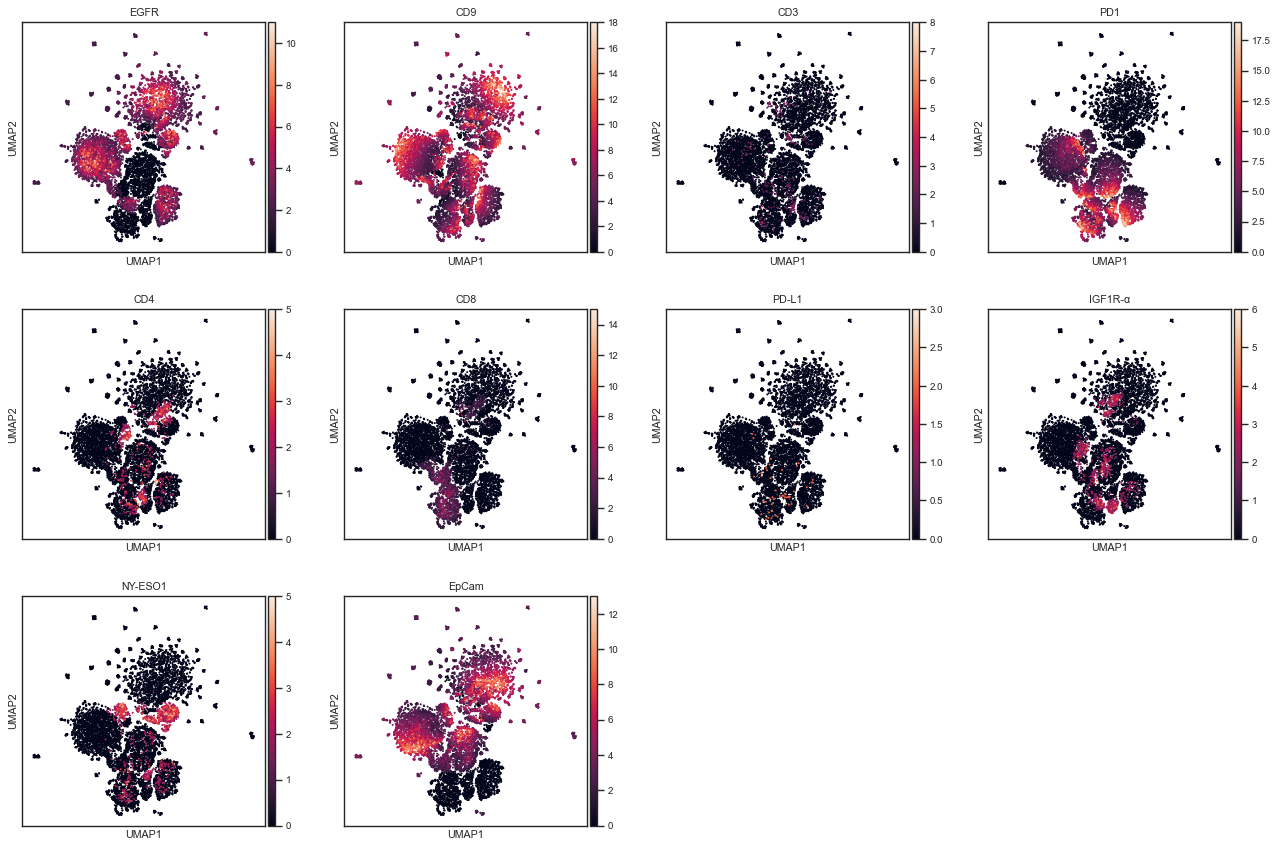

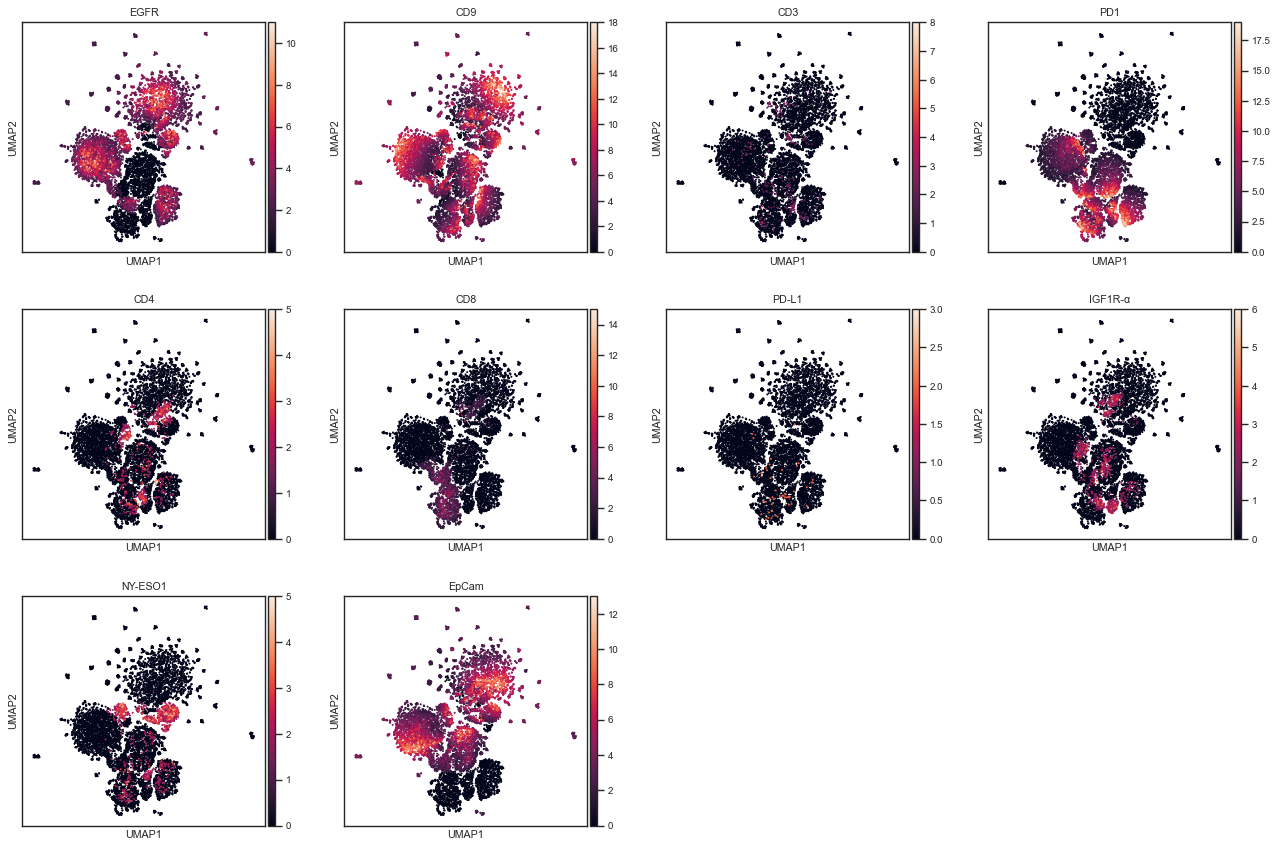

In [409]:
for ext in ["png", "svg"]:
    sc.pl.umap(
        adata, color=adata.var.index.to_list(), ncols=4, 
        save=f"{today()}_Patients_UMAP_targets.{ext}"
    )

0.1


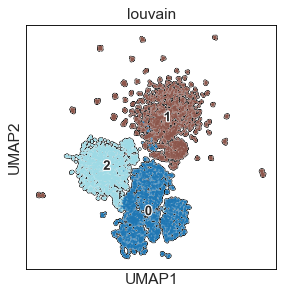

0.2


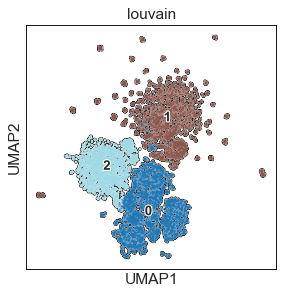

0.30000000000000004


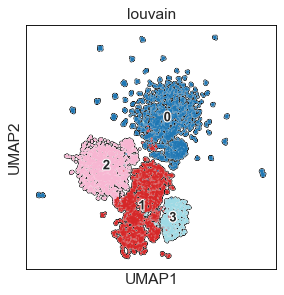

0.4


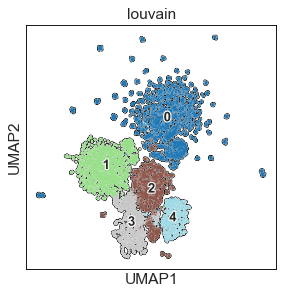

0.5


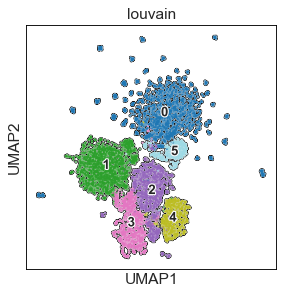

0.6


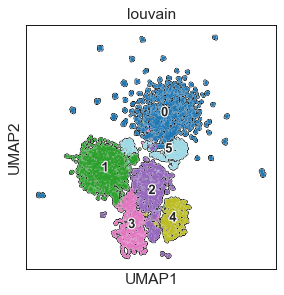

0.7000000000000001


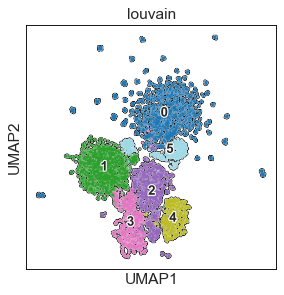

0.8


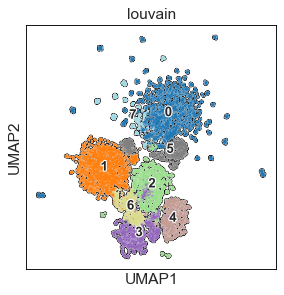

0.9


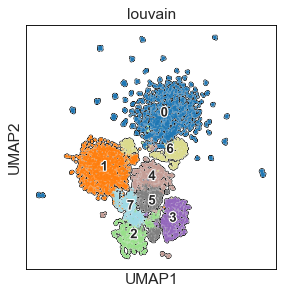

In [281]:
for res in np.arange(0.1,1.0,0.1):
    print(res)
    sc.tl.louvain(adata, resolution=res)
    sc.pl.umap(
        adata,
        color='louvain', 
        palette="tab20", 
        legend_loc='on data', 
        add_outline=True,
        legend_fontsize=12, 
        legend_fontoutline=2,
    )

In [282]:
#sc.tl.leiden(adata, resolution=0.2)
sc.tl.louvain(adata, resolution=0.6)

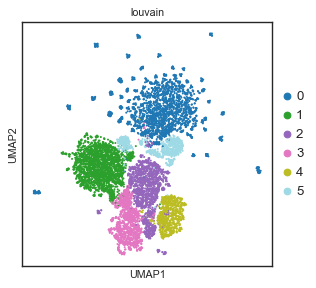

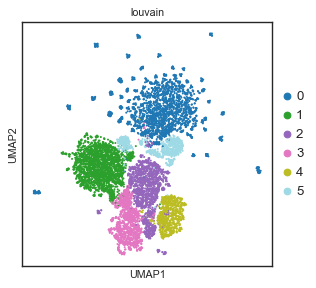

In [383]:
for ext in ["png", "svg"]:
    sc.pl.umap(
        adata,
        color='louvain', 
        palette="tab20", 
        save=f"{today()}_Patients_UMAP_louvain.{ext}",
        legend_fontsize=12, 
        legend_fontoutline=2,
    )

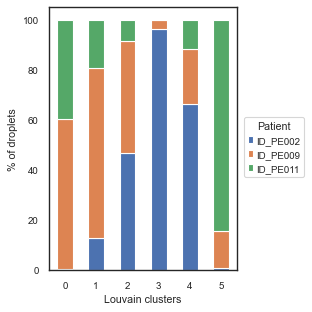

In [419]:
tmp = pd.crosstab(adata.obs['louvain'],adata.obs['Sample'], normalize='index')
tmp *= 100
ax = tmp.plot.bar(stacked=True)
_ = plt.legend(bbox_to_anchor=(1.01, 0.6), title="Patient", loc='upper left')
_ = ax.set_ylabel("% of droplets")
_ = ax.set_xlabel("Louvain clusters")
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
#ax.legend(loc='upper right')
plt.tight_layout()
for ext in ["png", "svg"]:
    plt.savefig(f"../figures/{today()}_Patients_louvain_proportions.{ext}", dpi=300)


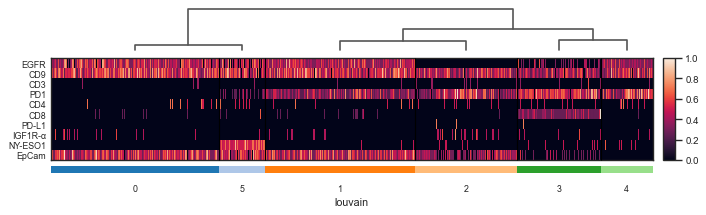

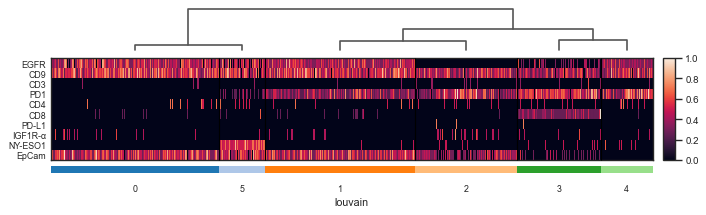

In [396]:
sc.tl.dendrogram(
    adata,
    groupby="louvain"
)
for ext in ["png", "svg"]:
    sc.pl.heatmap(
        adata, 
        var_names = adata.var.index.to_list(), 
        groupby=["louvain"], 
        save=f"{today()}_Patients_louvain_target_heatmap.{ext}",
        swap_axes = True, 
        standard_scale="var",
        use_raw=False,
        dendrogram=True
    )

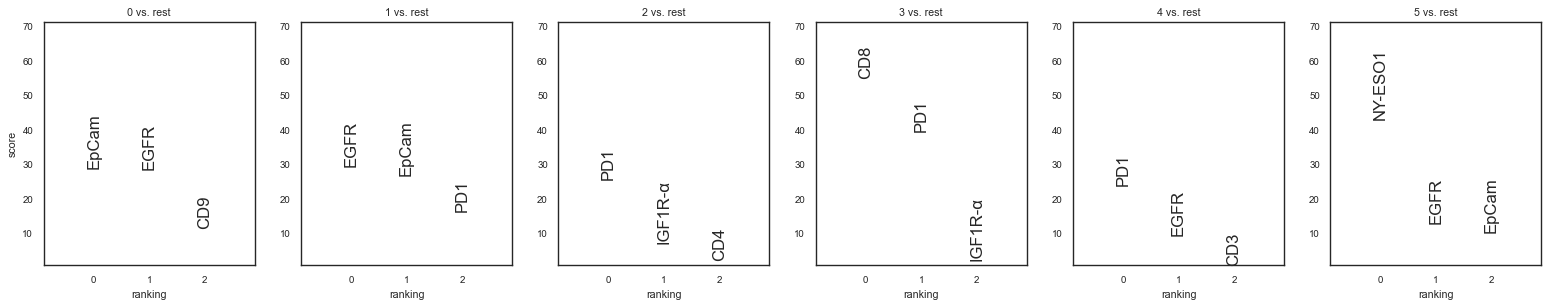

In [397]:
sc.tl.rank_genes_groups(adata, 'louvain', method='wilcoxon')
#for ext in ["png", "svg"]:
sc.pl.rank_genes_groups(
    adata, 
    groups=sorted(adata.obs["louvain"].unique(), key=int),#"'1','2','3','4'], 
    n_genes=3, 
    ncols=6,
    sharey=True, 
    fontsize=15
)#, save=f"211115_Patients_leiden_rankings.{ext}")


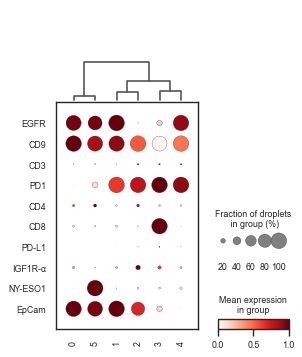

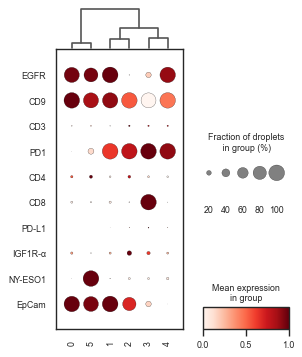

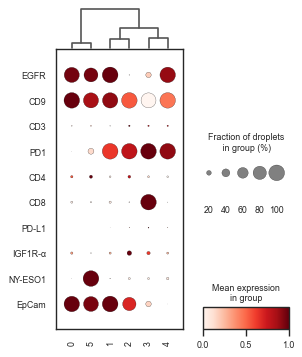

In [432]:
sc.tl.dendrogram(
    adata,
    groupby="louvain"
)

ax = sc.pl.dotplot(
        adata, 
        var_names = adata.var.index.to_list(), 
        groupby=["louvain"], 
        swap_axes = True,
        
        standard_scale="var",
        use_raw=False,
        dendrogram=True,
        return_fig=True,
        show=False
    )
ax.size_title = "Fraction of droplets\n in group (%)"
#ax.show()
for ext in ["png", "svg"]:
    ax.savefig(f"../figures/{today()}_Patients_louvain_target_dotplot.{ext}")

{'var_names': ['EGFR',
  'CD9',
  'CD3',
  'PD1',
  'CD4',
  'CD8',
  'PD-L1',
  'IGF1R-α',
  'NY-ESO1',
  'EpCam'],
 'var_group_labels': None,
 'var_group_positions': None,
 'var_group_rotation': None,
 'width': None,
 'height': None,
 'has_var_groups': False,
 'categories': Index(['0', '1', '2', '3', '4', '5'], dtype='object'),
 'obs_tidy':              EGFR       CD9       CD3       PD1       CD4       CD8  PD-L1  \
 louvain                                                                      
 4        0.432865  0.594709  0.000000  0.594709  0.000000  0.000000    0.0   
 3        0.000000  0.594709  0.432865  1.508699  0.000000  0.432865    0.0   
 4        0.594709  0.594709  0.432865  1.508699  0.000000  0.000000    0.0   
 2        0.000000  0.733971  0.000000  0.965083  0.000000  0.000000    0.0   
 3        0.432865  0.594709  0.000000  0.594709  0.000000  0.594709    0.0   
 ...           ...       ...       ...       ...       ...       ...    ...   
 5        0.452549  0.61

In [400]:
sc.tl.embedding_density(adata, groupby='Sample')

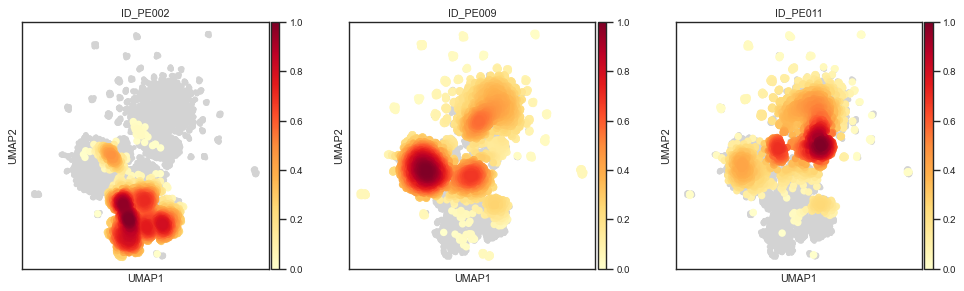

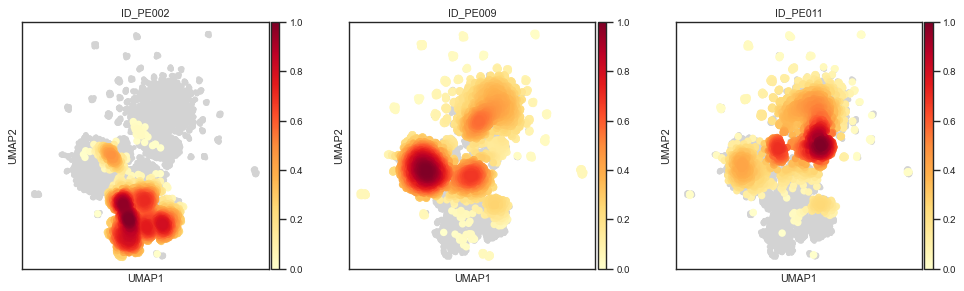

In [403]:
for ext in ["png", "svg"]:
    sc.pl.embedding_density(
        adata, groupby='Sample', vmax=1, vmin=0, 
        save=f"{today()}_Patients_UMAP_density.{ext}"
    )

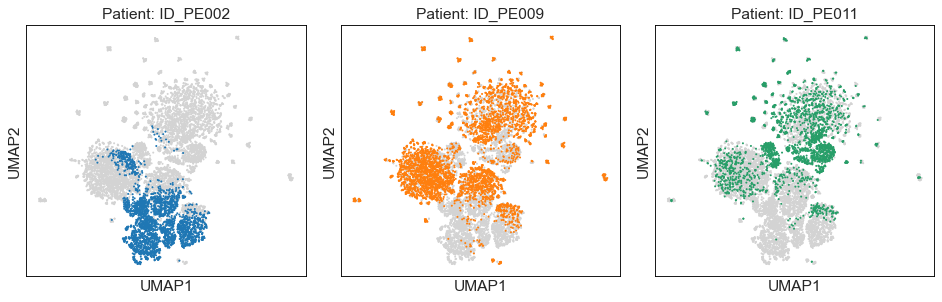

In [308]:
fig, axes = plt.subplots(ncols=3, figsize=(12,4))
for s, ax in zip(samples, axes.ravel()):
    sc.pl.umap(
        adata, 
        color="Sample", 
        groups=[s], 
        ax=ax, 
        title=f"Patient: {s}", 
        show=False, 
        na_in_legend=False, 
        legend_loc="top"
    )

plt.tight_layout()
plt.show()

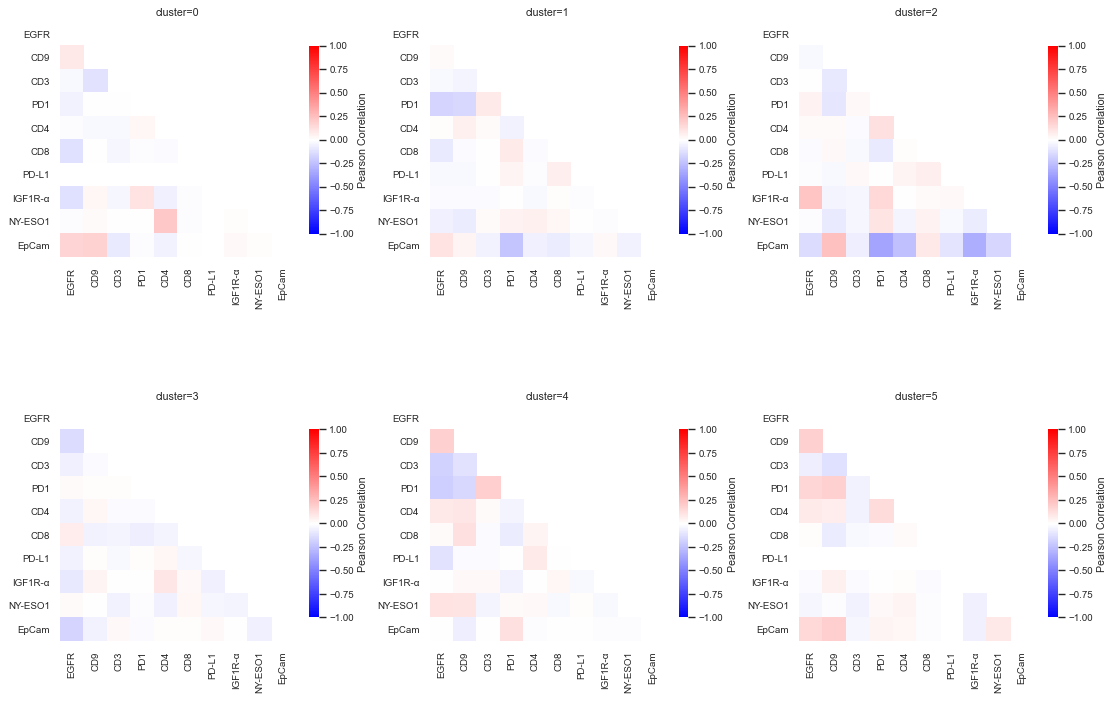

In [406]:
d = sc.get.obs_df(adata, keys=["louvain"] + adata.var.index.to_list(), use_raw=True)
clusters = sorted(np.unique(d["louvain"]))
nrows = len(clusters)//3
fig, axes = plt.subplots(nrows=nrows, ncols=3, figsize=(14,5*nrows))
for cluster, ax in zip(clusters, axes.ravel()):
    corr = d[(d["louvain"]==cluster)].loc[:,targets].corr("pearson", min_periods=100)
    corr[np.isnan]
    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(mask)] = True
    ax = sns.heatmap(corr, mask=mask, cmap="bwr", square=True, vmin=-1, vmax=1, 
                     #annot=True, fmt=".2f", annot_kws={"fontsize":7}, 
                     ax=ax,
                     cbar_kws={"label":"Pearson Correlation", "shrink":.5},)
    ax.set_title(f"cluster={cluster}")
plt.tight_layout()
for ext in ["png", "svg"]:
    plt.savefig(f"../figures/{today()}_Patient_louvain_pearson_correlation_heatmap.{ext}", dpi=300)

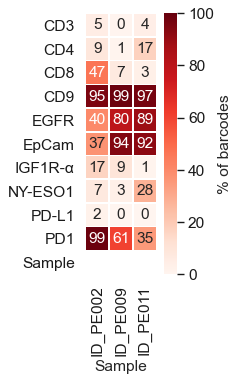

In [331]:
d = sc.get.obs_df(adata, keys=["Sample"] + adata.var.index.to_list(), use_raw=True)
d.loc[:,targets] = d.loc[:,targets].clip(upper=1)
#d = d.loc[:,targets+ ["Sample"]]
fig, ax = plt.subplots(figsize=(3,5))
sns.heatmap(data=d.groupby("Sample").apply(lambda x: 100 * x.sum() / x.count()).T, ax=ax,
           square=True, vmin=0, vmax=100, annot=True, fmt='.0f',
           linewidths=.5, cmap="Reds", cbar_kws={"label":"% of barcodes"})
_ = plt.ylabel("")
plt.tight_layout()

#for ext in ["png", "svg"]:
#    plt.savefig(f"../figures/{today}.Patients.heatmap_targets.{ext}", dpi=300)

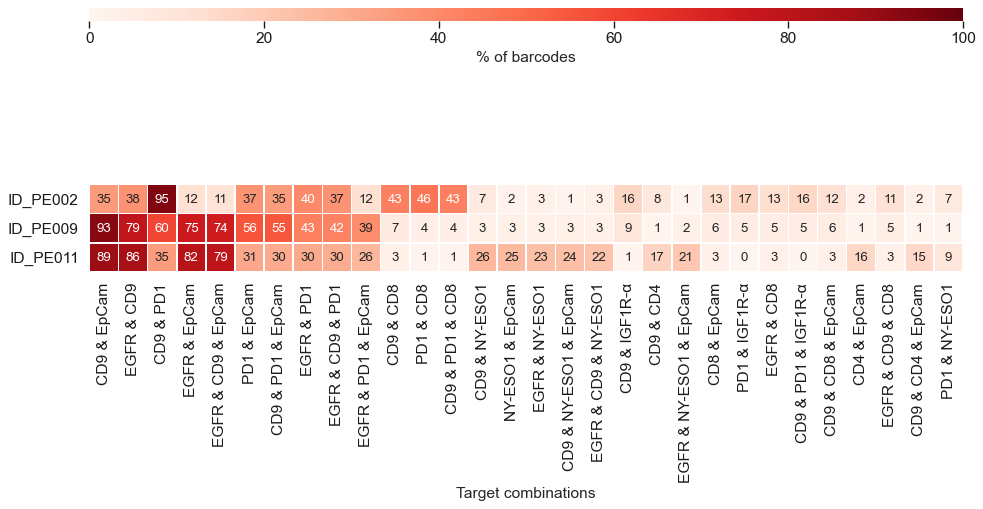

In [335]:
d = sc.get.obs_df(adata, keys=["Sample"] + adata.var.index.to_list(), use_raw=True)
d["Sample"] = d["Sample"].astype("object")
combos=[]
for i in range(2,4):
    for ts in combinations(targets, i):
        combo = " & ".join(ts)
        combos.append(combo)
        ts_list = list(ts)
        t = ts_list.pop()
        temp = (d[t] > 0)
        while ts_list:
            t = ts_list.pop()
            temp = np.logical_and(temp, (d[t] > 0))
        
        d[combo] = temp.astype(int) 

d = d.loc[:,combos+ ["Sample"]]
d = d.groupby("Sample").apply(lambda x: 100 * x.sum() / x.count())
maxd = d.mean()#agg(lambda x: x.std()/x.mean()).copy()
maxd.name = "max"
d = d.append(maxd)
d = d.sort_values(by="max", axis=1, ascending=False)
d = d.iloc[:3,:30]
grid_kws = {"height_ratios": (.03, .9), "hspace": .01}
f, (cbar_ax, ax) = plt.subplots(2, gridspec_kw=grid_kws, figsize=(14,7))
ax = sns.heatmap(data=d, ax=ax, cbar_ax=cbar_ax, 
                 cbar_kws={"orientation": "horizontal", "label":"% of barcodes"},
                 square=True, vmin=0, vmax=100, annot=True, fmt='.0f',
                 linewidths=.5, cmap="Reds", xticklabels=1,
                 annot_kws={"fontsize":12})
_ = plt.xlabel("Target combinations")
_ = plt.ylabel("")

#for ext in ["png", "svg"]:
#    plt.savefig(f"../figures/{today}.Patients.heatmap_combos.{ext}", dpi=300)

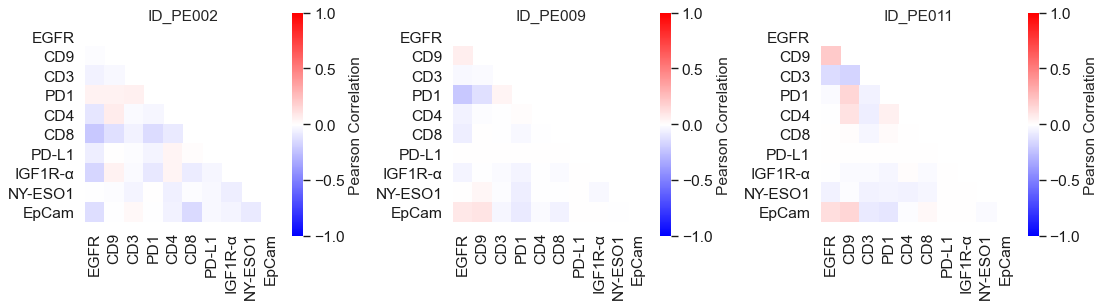

In [329]:
plotdf = sc.get.obs_df(adata, keys=["Sample"] + adata.var.index.to_list())

#sns.set(font_scale=0.8, style="white")
fig, axes = plt.subplots(ncols=3, figsize=(14,6))
for (sample, data), ax in zip(plotdf.groupby("Sample"), axes.ravel()):
    corr = data.corr("pearson", min_periods=100)
    corr[np.isnan(corr)] = 0
    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(mask)] = True
    ax = sns.heatmap(corr, mask=mask, cmap="bwr", square=True, vmin=-1, vmax=1, 
                     annot=False, fmt=".2f", annot_kws={"fontsize":7}, ax=ax,
                     cbar_kws={"label":"Pearson Correlation", "shrink":.5},)
    ax.set_title(sample)
#    plt.tight_layout()
#    for ext in ["png", "svg"]:
#        plt.savefig(f"images/210429_Patient_{l}_pearson_correlation_heatmap.{ext}", dpi=300)
#    plt.show()
plt.tight_layout()


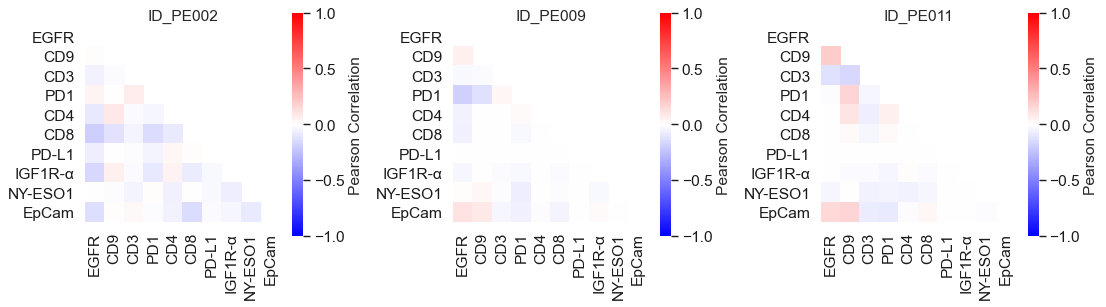

In [330]:
plotdf = sc.get.obs_df(adata, keys=["Sample"] + adata.var.index.to_list(), use_raw=True)

#sns.set(font_scale=0.8, style="white")
fig, axes = plt.subplots(ncols=3, figsize=(14,6))
for (sample, data), ax in zip(plotdf.groupby("Sample"), axes.ravel()):
    corr = data.corr("pearson", min_periods=100)
    corr[np.isnan(corr)] = 0
    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(mask)] = True
    ax = sns.heatmap(corr, mask=mask, cmap="bwr", square=True, vmin=-1, vmax=1, 
                     annot=False, fmt=".2f", annot_kws={"fontsize":7}, ax=ax,
                     cbar_kws={"label":"Pearson Correlation", "shrink":.5},)
    ax.set_title(sample)
#    plt.tight_layout()
#    for ext in ["png", "svg"]:
#        plt.savefig(f"images/210429_Patient_{l}_pearson_correlation_heatmap.{ext}", dpi=300)
#    plt.show()
plt.tight_layout()
